In [2]:
from plancraft.environments.env_real import RealPlancraft

env = RealPlancraft(
    inventory=[],
    symbolic_action_space=True,
    symbolic_observation_space=True,
    resolution=[512, 512],
    crop=True,
)
data = []

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [1]:
import json

with open("data/train.json", "r") as f:
    train = json.load(f)

seen_items = set()

for example in train:
    seen_items.update(example["inventory"].keys())
    seen_items.add(example["target"])

In [155]:
import random

def slot_to_bbox(slot: int):
    # crafting slot
    if slot == 0:
        # slot size: 25x25
        # top left corner: (x= 118, y=30)
        box_size = 25
        left_x = 117
        top_y = 29
    # crafting grid
    elif slot < 10:
        # slot size: 18x18
        # top left corner: (x = 28 + 18 * col, y = 16 + 18 * row)
        box_size = 18
        row = (slot - 1) // 3
        col = (slot - 1) % 3
        left_x = 27 + (box_size * col)
        top_y = 15 + (box_size * row)
    # inventory
    elif slot < 37:
        # slot size: 18x18
        # top left corner: (x= 6 + 18 * col, y=83 + 18 * row)
        box_size = 18
        row = (slot - 10) // 9
        col = (slot - 10) % 9
        left_x = 5 + (box_size * col)
        top_y = 82 + (box_size * row)
    # hotbar
    else:
        # slot size: 18x18
        # top left corner: (x= 6 + 18 * col, y=141)
        box_size = 18
        col = (slot - 37) % 9
        left_x = 5 + (box_size * col)
        top_y = 140
    return [left_x, top_y, left_x + box_size, top_y + box_size]


def sample_starting_inv():
    inventory = []
    for _ in range(random.randint(0, 35)):
        slot = random.randint(10, 44)
        inventory.append(
            {
                "type": random.choice(list(seen_items)),
                "slot": slot,
                "quantity": random.randint(1, 64),
            }
        )
    # sort by slot
    inventory = sorted(inventory, key=lambda x: x["slot"])
    return inventory

sample_starting_inv()

[{'type': 'crimson_stairs', 'slot': 35, 'quantity': 57},
 {'type': 'yellow_terracotta', 'slot': 42, 'quantity': 8}]

In [141]:
from PIL import Image
from transformers import AutoModelForVision2Seq, AutoProcessor


peft_model_id = "HuggingFaceM4/idefics2-8b-chatty"
model = AutoModelForVision2Seq.from_pretrained(
    "/nfs/public/hf/models/HuggingFaceM4/idefics2-8b-chatty",
    device_map="auto",
    local_files_only=True,
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


In [1]:
# model.load_adapter(peft_model_id)
# model.model.vision_model

In [147]:
# from peft import LoraModel, LoraConfig

# config = LoraConfig(
#     task_type="SEQ_2_SEQ_LM",
#     r=8,
#     lora_alpha=32,
#     target_modules=["q_proj", "v_proj"],
#     lora_dropout=0.01,
# )
# lora_model = LoraModel(model, config, "default")

In [87]:
data = []
for i in range(1):
    starting_inv = sample_starting_inv()
    env.fast_reset(new_inventory=starting_inv)
    obs, _, _, _ = env.step(env.action_space.no_op())

    # clean up inventory
    clean_inv = []
    for item in starting_inv:
        if item["quantity"] > 0:
            clean_inv.append(
                {
                    "type": item["type"],
                    "index": item["slot"],
                    "quantity": item["quantity"],
                    "bbox": slot_to_bbox(item["slot"]),
                }
            )
    obs["inventory"] = clean_inv
    data.append(obs)

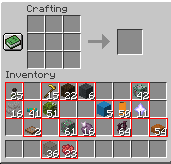

In [160]:
from PIL import Image, ImageDraw

img = Image.fromarray(data[-1]["pov"])
for item in data[-1]["inventory"]:
    draw = ImageDraw.Draw(img)
    draw.rectangle(item["bbox"], outline="red")
img.show()

In [89]:
import glob
import numpy as np
from PIL import Image, ImageSequence

observed_data = []

for f in glob.glob("/plancraft/outputs/oracle_real/train/0/*.json"):
    with open(f, "r") as file:
        inventories = json.load(file)["model_trace"]["inventory_history"]
    gif_path = str(f).replace(".json", ".gif")
    # load gif as list of images
    gif = Image.open(gif_path)
    frames = [frame.copy() for frame in ImageSequence.Iterator(gif)]
    if len(frames) != len(inventories):
        print(f)
    else:
        for frame, inv in zip(frames, inventories):
            clean_inv = []
            for item in inv:
                if item["quantity"] > 0:
                    clean_inv.append(
                        {
                            "type": item["type"],
                            "slot": item["index"],
                            "quantity": item["quantity"],
                            "bbox": slot_to_bbox(item["index"]),
                        }
                    )
            observed_data.append(
                {"inventory": clean_inv, "pov": np.array(frame.convert("RGB"))}
            )
    # assert len(frames) == len(inv), (len(frames), len(inv))

/plancraft/outputs/oracle_real/train/0/TRAIN0157.json
/plancraft/outputs/oracle_real/train/0/TRAIN0071.json


In [125]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class InventoryDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),  # Resize images to 224x224
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pov = item["pov"]
        pov = self.transform(pov)

        inventory = item["inventory"]
        types = [i["type"] for i in inventory]
        slots = [i["slot"] for i in inventory]
        quantities = [i["quantity"] for i in inventory]
        bboxes = [i["bbox"] for i in inventory]

        return pov, types, slots, quantities, bboxes


def collate_fn(batch):
    return tuple(zip(*batch))

dataset = InventoryDataset(observed_data)
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
batch = next(iter(train_loader))

In [135]:
import torch.nn as nn
import torchvision.models as models

class InventoryModel(nn.Module):
    def __init__(self, num_types, num_slots):
        super(InventoryModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the classification layer

        # Bounding box head
        self.bbox_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),  # 4 coordinates for the bounding box
        )

        # Slot index prediction head
        self.slot_head = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, num_slots), nn.Softmax(dim=1)
        )

        # Quantity prediction head
        self.quantity_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Softmax(dim=1), 
        )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad) // 1000000

    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox_head(features)
        # types = self.type_head(features)
        slots = self.slot_head(features)
        quantity = self.quantity_head(features)
        return bbox, slots, quantity


# Example usage
model = InventoryModel(num_types=100, num_slots=45)  # Replace with actual numbers
model = model.cuda()
# Count number of parameters
print(f"Model has {model.count_parameters()}M parameters")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has 11M parameters


# Get oracle O,A Dialogues

In [1]:
import json
import glob
import numpy as np
from PIL import Image, ImageSequence

oracle_trajectories_train = []
oracle_results = {
    "/plancraft/outputs/oracle_real/train/0/*.json": [],
    "/plancraft/outputs/oracle_real/val/0/*.json": [],
}
for path in oracle_results.keys():
    for f in glob.glob(path):
        with open(f, "r") as file:
            traj = json.load(file)

        images = []
        gif_path = str(f).replace(".json", ".gif")
        gif = Image.open(gif_path)
        for frame in ImageSequence.Iterator(gif):
            images.append(np.array(frame.convert("RGB")))
        traj["model_trace"]["images"] = images

        if (
            len(traj["model_trace"]["images"])
            == len(traj["model_trace"]["inventory_history"])
            == len(traj["model_trace"]["action_history"])
        ):
            oracle_results[path].append(traj)
        else:
            print(f)

In [26]:
import os
from plancraft.models.react_prompts import REACT_SYSTEM_PROMPT
from collections import defaultdict


def convert_obs_to_text(objective: str, inventory: list[dict]):
    return f"TASK: {objective}\ninventory={json.dumps(inventory)}"


def convert_action_to_text(action: dict):
    # {'action_type': 'move', 'slot_from': 17, 'slot_to': 1, 'quantity': 1}
    return f"act: {action['action_type']} from slot {action['slot_from']} to slot {action['slot_to']} with quantity {action['quantity']}"


# convert action and inventory to dialogue history
def convert_trajectory_to_base_dialogue(traj: dict):
    dialogue = [{"role": "system", "content": REACT_SYSTEM_PROMPT}]
    objective = traj["model_trace"]["objective"]
    for _, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": convert_obs_to_text(objective, inventory),
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": convert_action_to_text(action),
            }
        )
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example


# convert action and inventory to dialogue history
def convert_trajectory_to_image_dialogue(traj: dict):
    dialogue = [
        {"role": "system", "content": [{"type": "text", "text": REACT_SYSTEM_PROMPT}]}
    ]
    objective = traj["model_trace"]["objective"]
    images = []
    for image, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": [{"type": "image"}, {"type": "text", "text": objective}],
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": [{"type": "text", "text": convert_action_to_text(action)}],
            }
        )
        images.append(image)
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example, images


text_data = defaultdict(list)
mm_data = defaultdict(list)
for path, trajs in oracle_results.items():
    split = path.split("/")[-3]
    for traj in trajs:
        text_example = convert_trajectory_to_base_dialogue(traj)
        text_data[split].append(text_example)
        mm_example, example_imgs = convert_trajectory_to_image_dialogue(traj)
        mm_data[split].append(mm_example)
        # save imgs as png in format "data/oracle/{split}/{example_id}_{step}.gif"
        os.makedirs(f"data/oracle/{split}", exist_ok=True)
        for i, img in enumerate(example_imgs):
            Image.fromarray(img).save(
                f"data/oracle/{split}/{traj['example_id']}_{i}.png"
            )

    # save as jsonl file
    with open(f"data/oracle/{split}.jsonl", "w") as f:
        for example in text_data[split]:
            f.write(json.dumps(example) + "\n")

    with open(f"data/oracle/{split}.mm.jsonl", "w") as f:
        for example in mm_data[split]:
            f.write(json.dumps(example) + "\n")

# Generate Thought traces

In [1]:
import json
import pandas as pd

split = "train"
with open(f"data/{split}.json", "r") as f:
    examples = json.load(f)
df = pd.DataFrame(examples)

dialogues = []
with open(f"data/oracle/{split}.jsonl", "r") as f:
    for line in f:
        dialogues.append(json.loads(line))

dialogue_df = pd.DataFrame(dialogues)

df = pd.merge(df, dialogue_df, left_on="id", right_on="example_id", how="inner")

In [16]:
BASE_PROMPT = """
You are crafting in Minecraft.

The first 10 slots in the inventory are reserved for crafting and correspond to the minecraft crafting table.
[1, 2, 3]
[4, 5, 6] -> [0]
[7, 8, 9]

The crafting matrix is a 3x3 grid, and the output is sent to slot 0.
You cannot move or smelt items into output slot 0.
The remaining slots (10-45) are for storing items.

For a given observation action pair, you should explain the reasoning behind taking that action. Mention the state of the environment, what the next recipe to craft is (in the context of the greater planning problem) and why this move should be taken.

Examples:

TASK: Craft an item of type: andesite
Crafting path: [andesite]

1. inventory='[{"type": "diorite", "slot": 27, "quantity": 1},{"type": "cobblestone", "slot": 39, "quantity": 1}]'
action: move from slot 27 to slot 4 with quantity 1
thought: To solve this task I need to craft andesite. Andesite requires placing 1 diorite and 1 cobblestone side by side in the crafting table, therefore I will first need to move the diorite from slot 27 into the crafting grid. 

2. inventory=[{"type": "diorite", "slot": 4, "quantity": 1},{"type": "cobblestone", "slot": 39, "quantity": 1}]
action: move from slot 39 to slot 5 with quantity 1
thought: Since the diorite has been moved into the crafting grid, I now need to move the cobblestone to the right of it. Slot 5 is to the right of slot 4, and therefore I will move the cobblestone to slot 5.

3. inventory=[{"type": "andesite", "slot": 0, "quantity": 1},{"type": "diorite", "slot": 4, "quantity": 1},{"type": "cobblestone", "slot": 5, "quantity": 1}]
action: move from slot 0 to slot 15 with quantity 1
thought: Now I can craft the andesite by moving it from the craft slot (0) to a free inventory slot (eg., 15). 

TASK: Craft an item of type: iron_ingot
Crafting path: [iron_ingot]

1. inventory='[{"type": "iron_ore", "slot": 45, "quantity": 1},{"type": "cobblestone", "slot": 39, "quantity": 1}]
action: smelt from slot 45 to slot 44 with quantity 1
thought: To craft an iron_ingot, I need to smelt the iron_ore at slot 45 into an empty slot (eg., 44).

"""

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "/nfs/public/hf/models/meta-llama/Meta-Llama-3-70B"
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    local_files_only=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


In [12]:
from transformers import StopStringCriteria, StoppingCriteriaList

stopping_criteria = StoppingCriteriaList([StopStringCriteria(
    tokenizer=tokenizer, stop_strings=["\n", "\n\n", ".\n\n", "\n\n\n"]
)])

In [19]:
def generate_thoughts(row):
    step = 1
    task_message = BASE_PROMPT + row.messages[1]["content"].split("\n")[0]
    task_message += f"\nCrafting path: {row.optimal_path}"
    OTA_messages = []
    for i in range(1, len(row.messages), 2):
        user_entry = row.messages[i]
        assert user_entry["role"] == "user"
        assistant_entry = row.messages[i + 1]
        assert assistant_entry["role"] == "assistant"
        inventory = user_entry["content"].split("inventory=")[1]
        action = assistant_entry["content"]
        task_message += f"\n\n{step}. inventory={inventory}\naction: {action}\nthought:"
        tokenized_prompt = tokenizer(task_message, return_tensors="pt")
        outputs = model.generate(
            **tokenized_prompt,
            tokenizer=tokenizer,
            max_new_tokens=128,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
            stopping_criteria=[stopping_criteria],
        )
        # Decode the generated output
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).rstrip(
            "\n"
        )
        thought = generated_text.split("thought:")[-1].strip()
        OTA_messages.append(user_entry)  # Observation
        OTA_messages.append({"role": "assistant", "content": f"thought: {thought}"})  # Thought
        OTA_messages.append({"role": "user", "content": "Ok"})
        OTA_messages.append(assistant_entry) # Action
        task_message = generated_text
        step += 1
    return OTA_messages

# Convert and print the result
output = generate_thoughts(df.iloc[0])
print(output)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'role': 'user', 'content': 'TASK: Craft an item of type: red_dye\ninventory=[{"type": "torch", "quantity": 57, "index": 19}, {"type": "wooden_pickaxe", "quantity": 1, "index": 21}, {"type": "map", "quantity": 22, "index": 26}, {"type": "beetroot", "quantity": 1, "index": 35}, {"type": "lodestone", "quantity": 50, "index": 36}]'}, {'role': 'assistant', 'content': 'To craft a red_dye, I need to move the beetroot from slot 35 to slot 1.'}, {'role': 'user', 'content': 'Ok'}, {'role': 'assistant', 'content': 'act: move from slot 35 to slot 1 with quantity 1'}, {'role': 'user', 'content': 'TASK: Craft an item of type: red_dye\ninventory=[{"type": "red_dye", "quantity": 1, "index": 0}, {"type": "beetroot", "quantity": 1, "index": 1}, {"type": "torch", "quantity": 57, "index": 19}, {"type": "wooden_pickaxe", "quantity": 1, "index": 21}, {"type": "map", "quantity": 22, "index": 26}, {"type": "lodestone", "quantity": 50, "index": 36}]'}, {'role': 'assistant', 'content': 'Now that the red_dye i

In [24]:
df.iloc[0]["id"]

'TRAIN0001'